<a href="https://colab.research.google.com/github/nelsonsouzajr/GreenMind/blob/main/backend/GreenMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instala a biblioteca do Kaggle
!pip install -q kaggle

# Configura o diretório para a chave da API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset "New Plant Diseases Dataset"
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

# Descompacta os arquivos do dataset
!unzip -q new-plant-diseases-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:19<00:00, 119MB/s] 
100% 2.70G/2.70G [00:19<00:00, 150MB/s]


# Seção teste verificar se download foi realizado com sucesso.

Número total de classes (doenças/saudável): 38

As 5 primeiras classes encontradas:
['Soybean___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Cherry_(including_sour)___healthy', 'Tomato___Bacterial_spot', 'Apple___healthy']


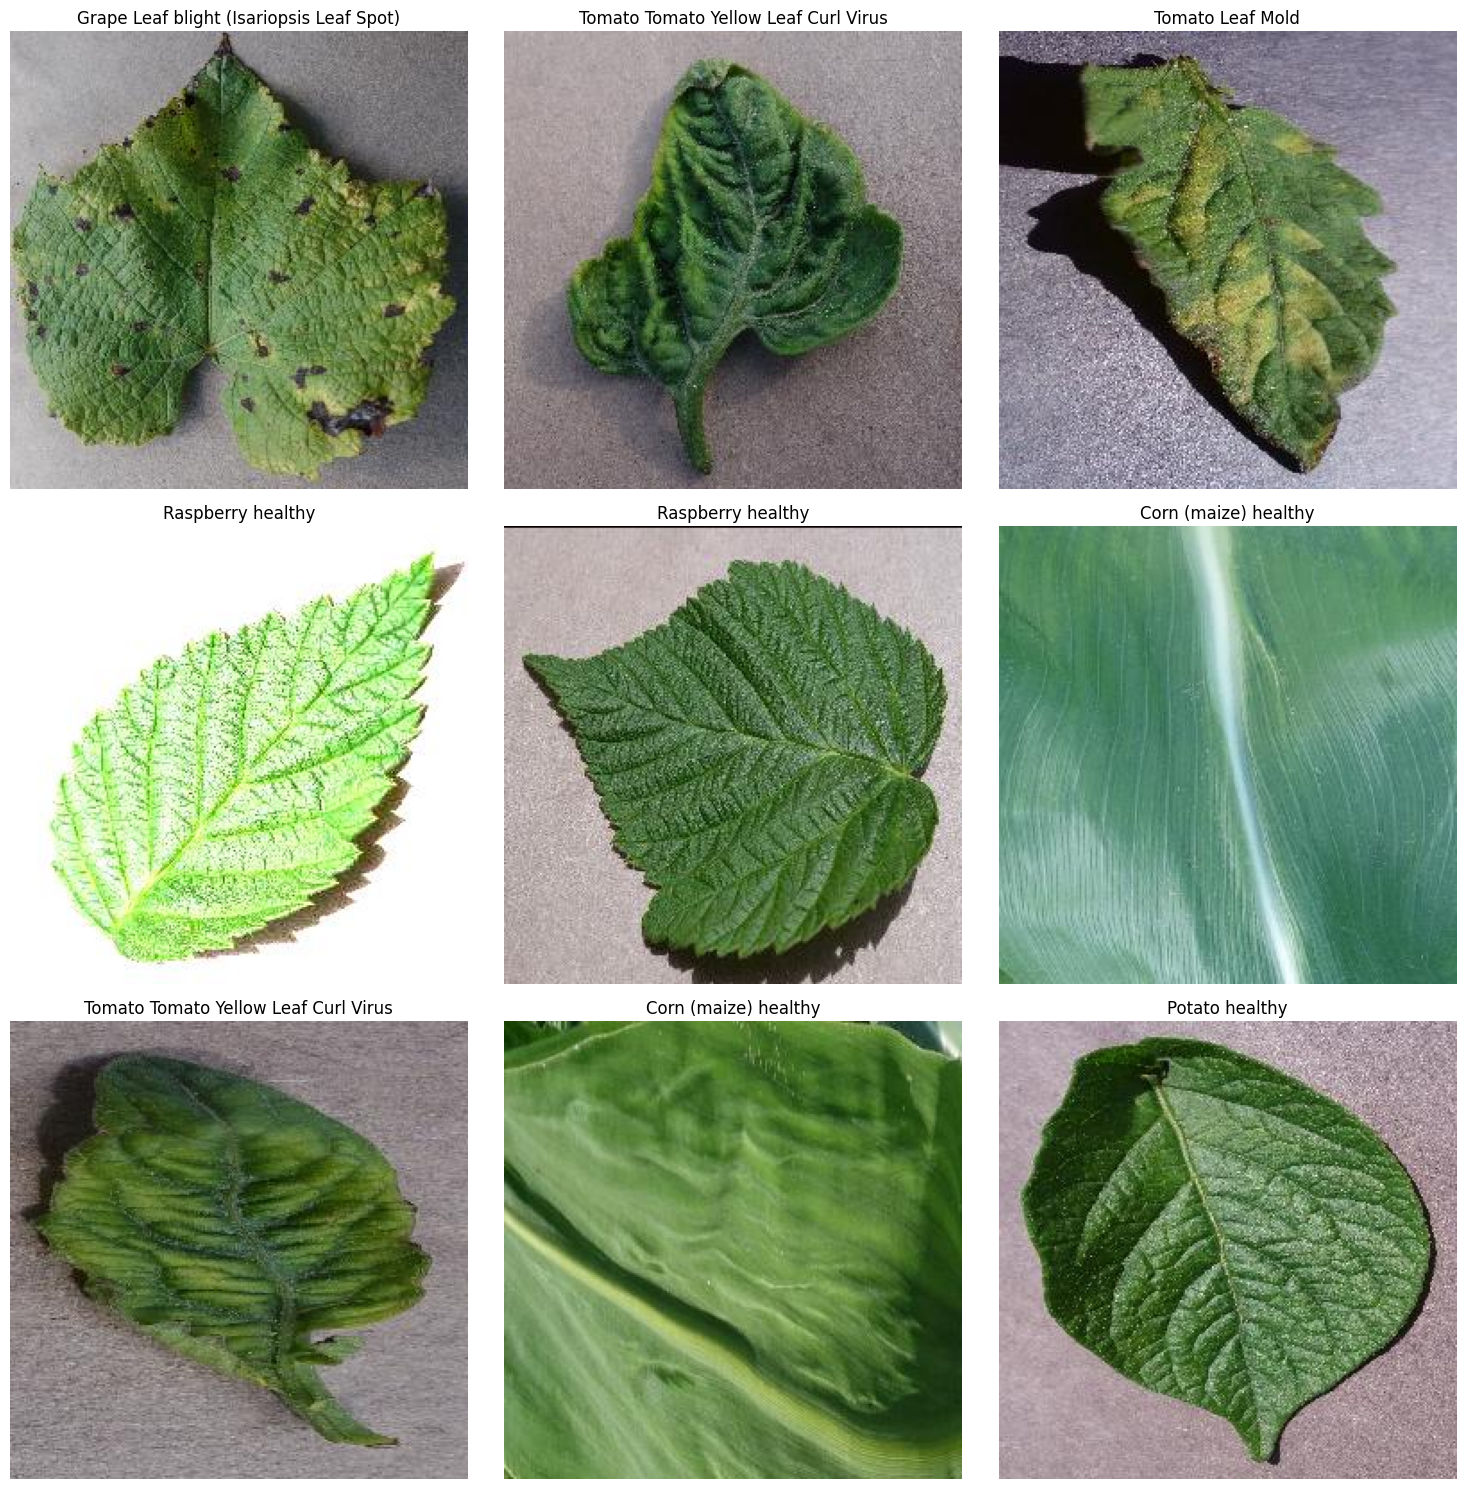

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# O dataset pode ter sido descompactado em diferentes estruturas de pastas.
# Este código tenta encontrar o diretório de treino correto.
base_dir = '/content/'
train_dir = ''

# Procura pelas pastas 'train' comuns em datasets do Kaggle
possible_paths = [
    os.path.join(base_dir, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'),
    os.path.join(base_dir, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'),
    os.path.join(base_dir, 'train')
]

for path in possible_paths:
    if os.path.exists(path):
        train_dir = path
        break

if not train_dir:
    print("Pasta de treino não encontrada! Verifique o nome da pasta descompactada no painel de arquivos à esquerda.")
else:
    # Lista todas as categorias de doenças (que são os nomes das subpastas)
    classes = os.listdir(train_dir)
    print(f"Número total de classes (doenças/saudável): {len(classes)}")
    print("\nAs 5 primeiras classes encontradas:")
    print(classes[:5])

    # Exibe 9 imagens aleatórias do dataset
    plt.figure(figsize=(15, 15))
    for i in range(9):
        plt.subplot(3, 3, i + 1)

        # Escolhe uma classe (pasta) aleatória
        random_class = random.choice(classes)
        class_path = os.path.join(train_dir, random_class)

        # Escolhe uma imagem aleatória dessa classe
        random_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image)

        # Carrega e exibe a imagem
        img = Image.open(image_path)
        plt.imshow(img)
        # Limpa o nome da classe para melhor visualização no título
        plt.title(random_class.replace('___', ' ').replace('_', ' '))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# TREINAMENTO / VALIDAÇÃO

In [3]:
import tensorflow as tf
import os # Importamos o 'os' para verificar o caminho

# Parâmetros para o nosso modelo
IMG_SIZE = (224, 224) # Tamanho padrão para muitos modelos de visão computacional
BATCH_SIZE = 32      # Quantas imagens o modelo vê de uma vez por 'rodada' de treino

# Verifica se a variável 'train_dir' existe e é válida antes de prosseguir
if 'train_dir' not in locals() or not os.path.exists(train_dir):
    print("A variável 'train_dir' não foi definida ou o caminho é inválido.")
    print("Por favor, execute a célula anterior (de exploração de dados) novamente para definir o caminho correto.")
else:
    # Criar o dataset de treinamento
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        label_mode='categorical',
        validation_split=0.2,  # 20% dos dados serão para validação
        subset='training',
        seed=42,               # 'seed' para garantir que a divisão seja sempre a mesma
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Criar o dataset de validação
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        label_mode='categorical',
        validation_split=0.2,
        subset='validation',
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Imprime os nomes das classes que o TensorFlow encontrou para confirmar
    class_names = train_dataset.class_names
    print(f"\nDados divididos com sucesso em {len(class_names)} classes.")

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.

Dados divididos com sucesso em 38 classes.


## Transfer Learning - MobileNetV2

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Garante que temos as variáveis da célula anterior
if 'IMG_SIZE' not in locals() or 'class_names' not in locals():
    print("Variáveis IMG_SIZE ou class_names não encontradas. Execute a célula anterior de divisão de dados.")
else:
    # --- 1. Carregar o Modelo Base (Nosso "Motor") ---
    IMG_SHAPE = IMG_SIZE + (3,) # Adiciona o canal de cor (RGB)

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False, # Crucial: Não incluir a camada final do modelo original
        weights='imagenet'   # Carregar os pesos pré-treinados no ImageNet
    )

    # --- 2. Congelar o Modelo Base ---
    # Dizemos ao Keras para não treinar as camadas que já são experientes
    base_model.trainable = False

    # --- 3. Construir Nosso Modelo Final ---
    # Vamos criar um novo modelo sequencial
    model = tf.keras.Sequential([
        # Começa com nosso motor pré-treinado
        base_model,
        # Camada para achatar os resultados do motor
        layers.GlobalAveragePooling2D(),
        # Camada de "decisão" final. O número de neurônios DEVE ser igual ao nosso número de classes.
        layers.Dense(len(class_names), activation='softmax')
    ])

    # --- 4. Visualizar a Arquitetura ---
    # Imprime um resumo da nossa arquitetura final
    print("Arquitetura do nosso modelo customizado:")
    model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Arquitetura do nosso modelo customizado:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
## Compilação

In [5]:
# Garante que temos o modelo da célula anterior
if 'model' not in locals():
    print("A variável 'model' não foi definida. Por favor, execute a célula anterior para construir a arquitetura.")
else:
    # Compila o modelo com o otimizador, a função de perda e a métrica
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Modelo compilado com sucesso!")

Modelo compilado com sucesso!


In [ ]:
## INICIAR O TREINAMENTO

In [6]:
# Garante que temos todas as variáveis necessárias
if 'model' not in locals() or 'train_dataset' not in locals() or 'validation_dataset' not in locals():
    print("Uma das variáveis (model, train_dataset ou validation_dataset) não foi definida. Execute as células anteriores.")
else:
    # Inicia o treinamento!
    print("Iniciando o treinamento do modelo...")

    # Guardamos o histórico do treinamento para analisar depois
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10  # Vamos treinar por 10 passadas completas no dataset
    )

    print("Treinamento concluído!")

Iniciando o treinamento do modelo...
Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2758s 2s/step - accuracy: 0.5370 - loss: 1.7674 - val_accuracy: 0.7552 - val_loss: 0.8489
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2737s 2s/step - accuracy: 0.7744 - loss: 0.7893 - val_accuracy: 0.7900 - val_loss: 0.7066
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2795s 2s/step - accuracy: 0.8106 - loss: 0.6447 - val_accuracy: 0.8145 - val_loss: 0.6142
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2783s 2s/step - accuracy: 0.8320 - loss: 0.5642 - val_accuracy: 0.8180 - val_loss: 0.5943
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2755s 2s/step - accuracy: 0.8459 - loss: 0.5136 - val_accuracy: 0.8306 - val_loss: 0.5428
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2854s 2s/step - accuracy: 0.8567 - loss: 0.4740 - val_accuracy: 0.8363 - val_loss: 0.5244
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2837s 2s/step - accuracy: 0.8647 - loss: 0.4456 - val_accuracy: 0.8414 - val_loss: 0.5071
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━

## ANALISE (2 graficos)

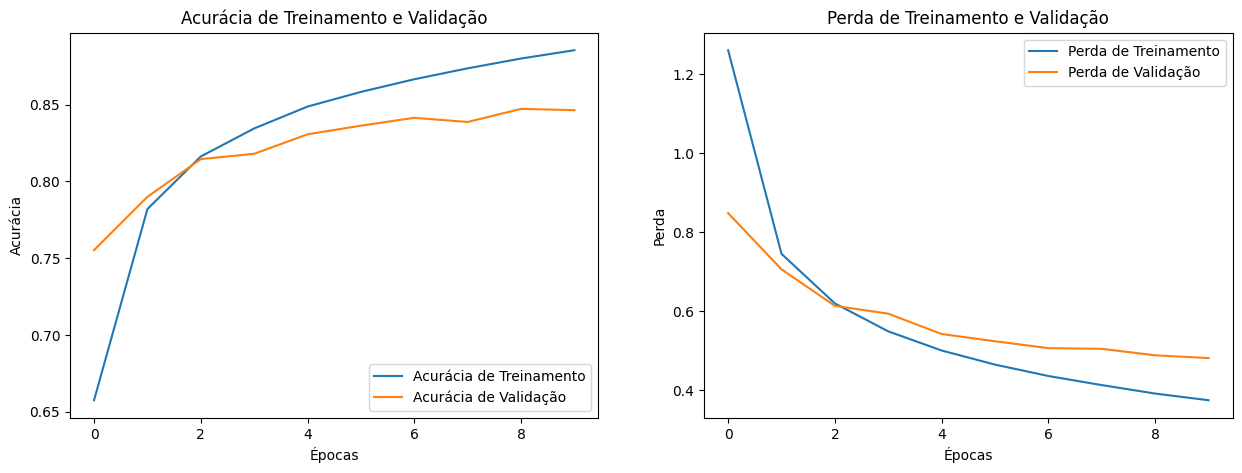


Acurácia final de validação: 84.64%


In [7]:
import matplotlib.pyplot as plt

# Garante que a variável 'history' existe
if 'history' not in locals():
    print("A variável 'history' não foi encontrada. Execute a célula de treinamento ('model.fit') primeiro.")
else:
    # Pega os dados do histórico de treinamento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Usamos len(acc) para o caso de o treino ter sido interrompido

    # Cria a figura e os eixos para os gráficos
    plt.figure(figsize=(15, 5))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treinamento')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')

    plt.show()

    # Imprime a acurácia final de validação
    print(f"\nAcurácia final de validação: {val_acc[-1]:.2%}")

# Compilação e Treinamento (Versão 2)

## Data Augmentation - - - Atualização do MobileNetV2

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Garante que temos as variáveis da célula anterior
if 'IMG_SIZE' not in locals() or 'class_names' not in locals():
    print("Variáveis IMG_SIZE ou class_names não encontradas. Execute as células anteriores.")
else:
    # --- 1. Criar a camada de Data Augmentation ---
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ], name="data_augmentation")

    # --- 2. Reconstruir o Modelo Completo com a nova camada ---
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Usamos a API Funcional do Keras para maior flexibilidade
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    # A primeira camada que a imagem vê é a de augmentation
    x = data_augmentation(inputs)

    # A base pré-treinada processa a imagem já alterada
    x = base_model(x, training=False)

    # Adicionamos as camadas finais que já conhecemos
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    # Criamos o modelo final, conectando a entrada com a saída
    model = tf.keras.Model(inputs, outputs)

    # --- 3. Visualizar a Nova Arquitetura ---
    print("Arquitetura do novo modelo com Data Augmentation:")
    model.summary()

Arquitetura do novo modelo com Data Augmentation:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Garante que temos o modelo e os datasets
if 'model' not in locals() or 'train_dataset' not in locals() or 'validation_dataset' not in locals():
    print("Uma das variáveis necessárias não foi encontrada. Execute as células anteriores.")
else:
    # 1. Compilar o novo modelo (usando as mesmas configurações)
    print("Compilando o novo modelo...")
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Modelo compilado com sucesso!")

    # 2. Iniciar o novo treinamento
    print("\nIniciando o segundo treinamento (com Data Augmentation)...")
    history_with_aug = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10 # Vamos manter 10 épocas para comparar
    )
    print("Segundo treinamento concluído!")

Compilando o novo modelo...
Modelo compilado com sucesso!

Iniciando o segundo treinamento (com Data Augmentation)...
Epoch 1/10
  13/1758 ━━━━━━━━━━━━━━━━━━━━ 47:52 2s/step - accuracy: 0.0153 - loss: 4.0874

KeyboardInterrupt: 